<a href="https://colab.research.google.com/github/polo2718/hrv_analysis/blob/main/HRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar paquetes y librerías necesarios

In [ ]:
# Solo ejecuta este comando si no has instalado la librería HRV analysis
!pip install pyHRV
!pip install biosppy

In [ ]:
# Solo ejecuta estos comandos si nunca has instalado GCloud
# Autenticar usario de google, instalar e iniciar GCloud
from google.colab import auth
auth.authenticate_user()

# Instalar el SDK de GCloud
!curl https://sdk.cloud.google.com | bash


# Obtener datos de Physionet
Conectar a la base de datos de Physionet para extraer ECGs usando Google Cloud


In [ ]:
# Iniciar GCloud
!gcloud init
# Copiar base de datos de Physionet
!gsutil -m cp -r gs://ecg-spider-clip-1.0.0.physionet.org .

# Visualizar un ECG

Para ello hay ingresar a los datos descargados de physionet. Al haber ejecutado el comando anterior, se debió haber generado una carpeta en la ruta "/content/ecg-spider-clip-1.0.0.physionet.org"
Dentro de esta carpeta hay datos de múltiples pacientes.

Cada paciente tiene una carpeta asociada, por ejemplo, VP02. Dentro de esta carpeta hay un archivo de texto nombrado "BitalinoECG.txt" que contiene los datos de electrocardiografía de ese paciente en específico.
La primera columna de este archivo contiene los datos de voltaje medidos en mV. La segunda columna contiene los datos temporales en un formato "hhmmss.millisegundos"


Comenzamos por importar las liberías de python necesarias para la visualización.



In [ ]:
import numpy as np # librería para facilitar operaciones numéricas
import os # librería para generar rutas a archivos contenidos en disco
import matplotlib.pyplot as plt # Librería para generar graficas
import pandas as pd # librería para facilitar lectura de datos
from scipy.signal import find_peaks # función para encontrar picos en señal
import pyhrv # librería para realizar análisis de HRV
import biosppy # libreria para realizar procesamiento de señales biomedicas

Continuamos por extraer los datos de un paciente en específico

In [ ]:
# Definir una función para ayudarnos a leer los datos de un paciente específico
def retrieve_data(patientID='VP02'):
  '''
  Leer los datos asociados a un paciente
  param: patientID Identificador de paciente

  returns: un tuple que contiene dos arreglos para tiempo y valores
  de ecg en la forma (t, ecg)
  t: arreglo que contiene puntos temporales en [ms]
  ecg: arreglo que contiene valores de la señal de ECG en [mV] correspondientes
  a cada valor de tiempo
  '''
  # Generar la ruta (path) al archivo de ECG que corresponde al paciente seleccionado
  dataset_path = '/content/ecg-spider-clip-1.0.0.physionet.org'
  ecg_file_path = os.path.join(dataset_path, patientID, 'BitalinoECG.txt')
  print("Leyendo el archivo: {}".format(ecg_file_path))

  # Leer el archivo usando la librería pandas
  colnames = ['ecg','time_stamp','raw'] # la primera columna contiene el ecg la
  # segunda datos de tiempo y la tercera indica el tipo de medición
  data = pd.read_csv(ecg_file_path,sep='\t', header=None, names=colnames)
  
  # extraer los datos de ecg
  ecg = data['ecg'].to_numpy()
  #frecuencia de muestreo
  fs = 100.0 # medida en Hz
  # generar arreglo de tiempo usando la frecuencia de muestreo
  t = np.linspace(start=0.0, stop=1/fs *(len(ecg)-1), num=len(ecg))
  t = t*1000 # multiplicar por mil para convertir a [ms]
  print('La señal se ha leído correctamente')
  return t, ecg


In [ ]:
# Usar la función para leer los datos de un paciente en específico.
# Se generan dos arreglos: el primero contiene los puntos en tiempo medidos en
# [ms], mientras que el segundo contiene los datos de la señal en [mV]
t, ecg = retrieve_data('VP05') 

Leyendo el archivo: /content/ecg-spider-clip-1.0.0.physionet.org/VP05/BitalinoECG.txt
La señal se ha leído correctamente


Podemos graficar la señal obtenida del archivo:

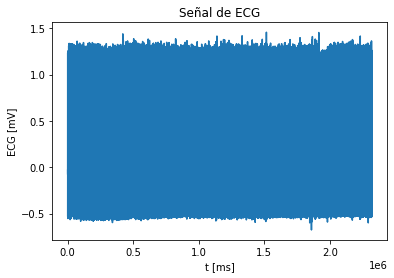

In [ ]:
plt.plot(t, ecg)
plt.xlabel('t [ms]')
plt.ylabel('ECG [mV]')
plt.title('Señal de ECG')
plt.show()

Como podrás observar, la señal no es legible. Lo anterior es porque estamos graficando muchos puntos en el tiempo. En total estamos graficando más de 2000 s.

Lo que podemos hacer es limitar nuestra gráfica a una ventana de tiempo reducida. 
Por ejemplo, grafiquemos los primeros 5s (5,000 ms)

In [ ]:
# Definir una función para extraer una ventana temporal de una señal
def temporal_window(t, signal, start_time, stop_time, fs=100):
  '''
  Extraer una ventana temporal de una señal definida.

  Parameters:
  t:  arreglo que contiene los puntos temporales de la señal en [ms]
  signal: arreglo que contiene los valores de la señal para cada punto de tiempo
  start_time: tiempo inicial de la ventana temporal, definido en [ms]
  stop_time: tiempo final de la ventana temporal, definido en [ms]
  fs: frecuencia de muestreo (default fs=100), medido en [Hz]

  Returns
  Tuple: (t, signal)
    t: arreglo que contiene puntos temporales en de la señal extraída [ms]
    signal: arreglo que contiene valores de la señal extraída
  '''
  # Garantizar que la operación de extracción pueda realizarse
  # Si no es posible, entonces generar un error
  if start_time>=stop_time:
    raise ValueError('El valor start_time={} debe ser menor a el valor'
                    ' stop_time={}'.format(start_time, stop_time))
  
  # Calcular el periodo de muestreo en milisegundos
  ts=1.0/fs * 1000 
  # Usando el periodo de muestreo calcular los puntos iniciales y finales
  # de los arreglos proporcionados.
  initial_idx = int(start_time // ts)
  stop_idx = int(stop_time // ts)

  # Extraer los datos de los arreglos originales
  t = t[initial_idx : stop_idx]
  signal = signal[initial_idx:stop_idx]
  return t,signal

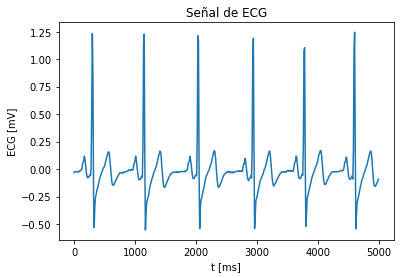

In [ ]:
# Usar la función para extraer una ventana temporal de la señal
start_time = 0.0 #[ms]
stop_time = 5000.0 #[ms]
t_w, ecg_w = temporal_window(t, ecg, start_time, stop_time)

# Graficar
plt.plot(t_w, ecg_w)
plt.xlabel('t [ms]')
plt.ylabel('ECG [mV]')
plt.title('Señal de ECG')
plt.show()

Al usar una ventana temporal, podemos ver una señal clara del ECG de este paciente.

# Calcular la posición de los picos R del complejo QRS de la señal de ECG

El siguiente paso para realizar un análisis de la VFC, es ubicar los puntos de la señal donde existe un pico R. Esto se debe hacer para poder calcular la cantidad de tiempo entre ellos.

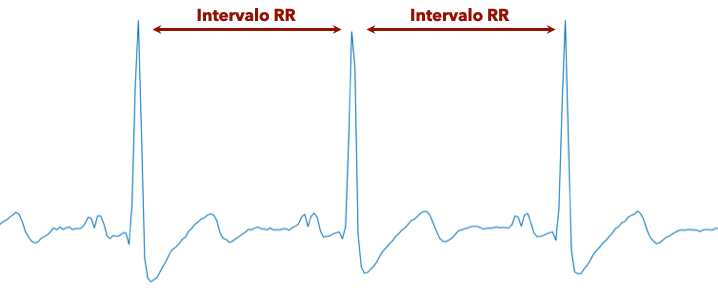

A continuación se desarrolla un algoritmo para extraer los picos R usando una técnica conocida como "template matching".

Básicamente se genera una señal que funciona como un "template" y se calcula la correlación cruzada de dicha señal con el ECG.

Para una demostración de la operación observa la siguiente imágen:

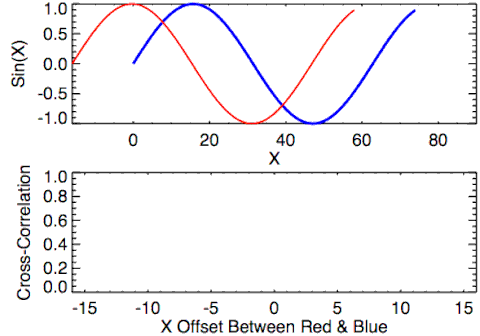

La señal de color azul es una señal que se eligió con fines demostrativos $sin(x)$. La puedes considerar como la señal original que se quiere analizar. Por otra parte, la señal de color rojo es el "template". La señal en color verde es el resultado de calcular la correlación cruzada.

Nota como el valor de la correlación cruzada cambia conforme se desplaza la señal roja de izquierda a derecha.

Justo cuando la señal del templete coincide exactamente con la señal original, se produce un valor máximo en la señal verde. Esto se debe a que en este punto, la similaridad de las dos señales es máxima. De hecho, justo en este punto son iguales. Por lo tanto, puedes considerar la medida de correlación cruzada una medida de similaridad.

La operación de correlación puede ser utilizada para reconocer características en señales más complejas (como el ECG), siempre y cuando se utilice un templete adecuado.

## Crear "template"
De acuerdo a Nguyen et.al. [1]. Podemos utilizar una señal triangular con una base similar a la duración del complejo QRS para detectarlo de manera robusta.
La longitud de la base se determina según la duración del complejo QRS que es alrededor de 80-120 ms.
Aquí usaremos el punto medio de este rango (100 ms)

In [ ]:
# Definimos una función para generar una señal triangular que funcionará
# como templete
def triangular_template(base=100.0, fs=100):
  '''
  Crea una señal triangular con una base de longitud deseada.

  Parameters:
  base: la base de la señal en [ms]
  fs: Frequencia de muestreo [Hz]
  Returns:
  Tuple: (t, signal)
    t: arreglo que contiene puntos temporales de la señal generada [ms]
    signal: arreglo que contiene los valores para la señal triangular deseada
  '''
  # Generar vector de tiempo en milisegundos
  ts = 1.0/fs * 1000 # periodo de muestra en ms
  t = np.linspace(start=0.0, stop=base, num=int(base/ts)+1)
  # Calcular los valores de salida de la señal
  template = []
  for tpoint in t:
    if tpoint<base/2:
      y = (2.0/base) * tpoint
    else:
      y = -(2.0/base) * tpoint + 2.0
    template.append(y)

  return t,np.array(template)

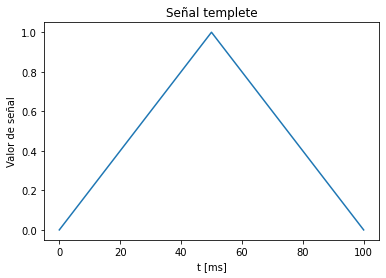

In [ ]:
# Llamar función
t_template , template = triangular_template(base=100.0, fs=100) 

# Graficar
plt.plot(t_template, template)
plt.xlabel('t [ms]')
plt.ylabel('Valor de señal')
plt.title('Señal templete')
plt.show()

## Calcular correlación

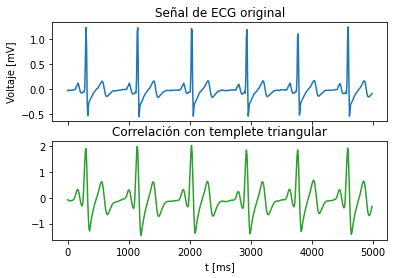

In [ ]:
# Calcular correlación normalizada
corr_w = np.correlate(ecg_w,template, mode='same')

# Graficar tanto el ECG como el resultado de la correlación para hacer un
# comparativo.
fig, axs = plt.subplots(2)
axs[0].plot(t_w, ecg_w)
axs[0].set_title('Señal de ECG original')
axs[1].plot(t_w, corr_w, 'tab:green')
axs[1].set_title('Correlación con templete triangular')
# set labels
plt.setp(axs[0], ylabel='Voltaje [mV]')
plt.setp(axs[1], xlabel='t [ms]')
for ax in axs.flat:
  ax.label_outer()


La correlación máxima se da justo en los picos R. Ahora extraeremos las ubicaciones de estos utilizando un umbral y la función find_peaks de scipy.

Text(0.5, 0, 't[ms]')

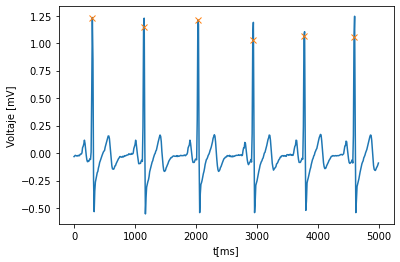

In [ ]:
# obtener los indices en el arreglo de correlación donde ocurre un máximo
peak_idx, _ = find_peaks(corr_w, height=1.2, distance=30)
# Graficar picos detectados sobre señal original
plt.plot(t_w, ecg_w)
plt.plot(t_w[peak_idx], ecg_w[peak_idx], "x")
plt.ylabel('Voltaje [mV]')
plt.xlabel('t[ms]')

la operación de correlación es necesaria para obtener los picos correctamente, aún cuando la señal de ECG tenga artefactos considerables (como los producidos por la respiración o movimientos musculares)

In [ ]:
# Definamos una función para calcular los picos de forma directa usando
# los comandos estudiados anteriormente
def signal_peaks(t, signal, template_base=100.0, threshold=1.2):
  # Generar señal triangular
  _,template = triangular_template(template_base)
  # Calcular correlación
  corr = np.correlate(signal,template, mode='same')
  # extraer picos
  peak_idx, _ = find_peaks(corr, height=threshold, distance=30)
  return peak_idx

Text(0.5, 0, 't[ms]')

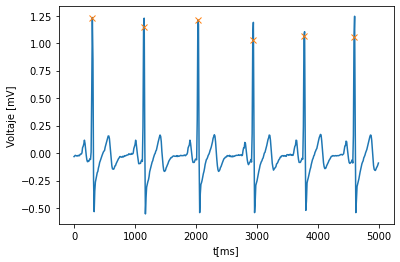

In [ ]:
# Usar función para replicar la extracción de picos
peak_idx = signal_peaks(t_w, ecg_w, template_base=100.0, threshold=1.7)
# Graficar
plt.plot(t_w, ecg_w)
plt.plot(t_w[peak_idx], ecg_w[peak_idx], "x")
plt.ylabel('Voltaje [mV]')
plt.xlabel('t[ms]')

# Calcular intervalo RR
Una vez teniendo los picos R, podemos proceder a calcular el intervalo RR.
Simplemente tenemos que calcular diferencias entre los tiempos donde ocurren los picos.

Intervalos RR en señal = [840. 890. 900. 840. 820.]


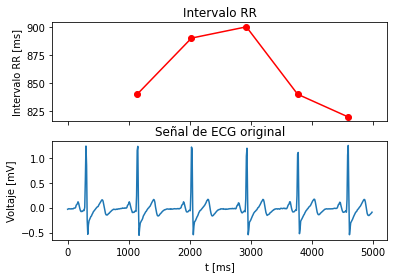

In [ ]:
# Tiempo donde ocurren los picos
t_w_peak = t_w[peak_idx] 
# Calcular diferencia entre los tiempos donde ocurren los picos
rr_w = np.diff(t_w_peak)
print('Intervalos RR en señal = {}'.format(rr_w))

# Graficar intervalo RR vs tiempo
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(t_w_peak[1:],rr_w, "-ro")
axs[0].set_title('Intervalo RR')
axs[1].plot(t_w, ecg_w)
axs[1].set_title('Señal de ECG original')
# labels
plt.setp(axs[0], ylabel='Intervalo RR [ms]')
plt.setp(axs[1], ylabel='Voltaje [mV]')
plt.setp(axs[1], xlabel='t [ms]')

for ax in axs.flat:
  ax.label_outer()

Ahora podemos hacer el cálculo de los intervalos RR para toda la adquisición de este paciente. Es decir, ya no usaremos la ventana temporal.

2977


Text(0.5, 1.0, 'Intervalo RR vs tiempo')

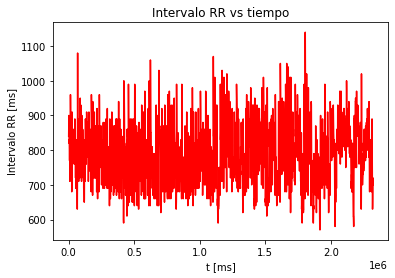

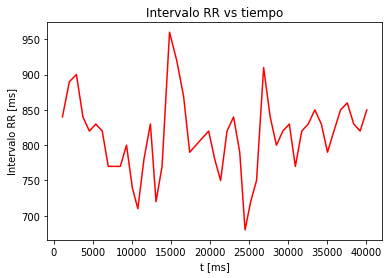

In [ ]:
# Extraer los picos R
peak_idx = signal_peaks(t, ecg, template_base=100.0, threshold=1.3)
# Tiempo donde ocurren los picos
t_peak = t[peak_idx] 
# Calcular diferencia 
rr = np.diff(t_peak)

# Graficamos la señal que describe los intervalos RR en función del tiempo
plt.figure()
plt.plot(t_peak[1:], rr, '-r')
plt.ylabel('Intervalo RR [ms]')
plt.xlabel('t [ms]')
plt.title('Intervalo RR vs tiempo')
print(len(t_peak))
# También podemos graficar una pequeña porción
plt.figure()
plt.plot(t_peak[1:50], rr[:49], '-r')
plt.ylabel('Intervalo RR [ms]')
plt.xlabel('t [ms]')
plt.title('Intervalo RR vs tiempo')

Nota como los intervalos RR no son constantes a lo largo del tiempo.

# Análisis de la variabilidad de la Frecuencia Cardiaca

Utilizaremos la librería pyHRV (https://pyhrv.readthedocs.io/en/latest/index.html)
para estudiar las características de la señal obtenida en el punto anterior.



## Análisis temporal

/usr/local/lib/python3.6/dist-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '



Resultados:
Mean=779.616935483871
Mean=779.616935483871
SDNN=85.94108458109679
Min=570.0
Max=1140.0
rMSSD=58.74828801367323
nn50=760
pnn50=25.546218487394956


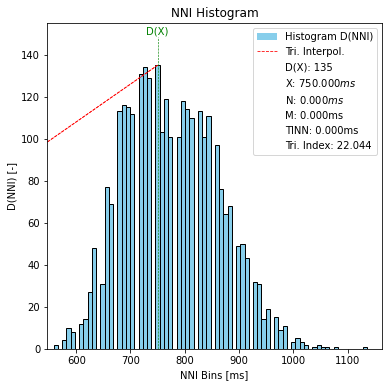

In [ ]:
# Realizar análisis temporal
results_time = pyhrv.time_domain.time_domain(nni=rr, sampling_rate=100)

# Mostrar resultados
print('\nResultados:')
print('Mean={}'.format(results_time['nni_mean']))
print('Mean={}'.format(np.mean(rr)))
print('SDNN={}'.format(results_time['sdnn']))
print('Min={}'.format(results_time['nni_min']))
print('Max={}'.format(results_time['nni_max']))
print('rMSSD={}'.format(results_time['rmssd']))
print('nn50={}'.format(results_time['nn50']))
print('pnn50={}'.format(results_time['pnn50']))



## Análisis en frecuencia

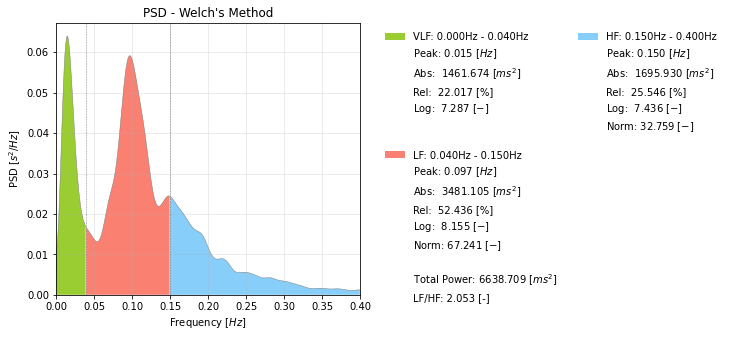

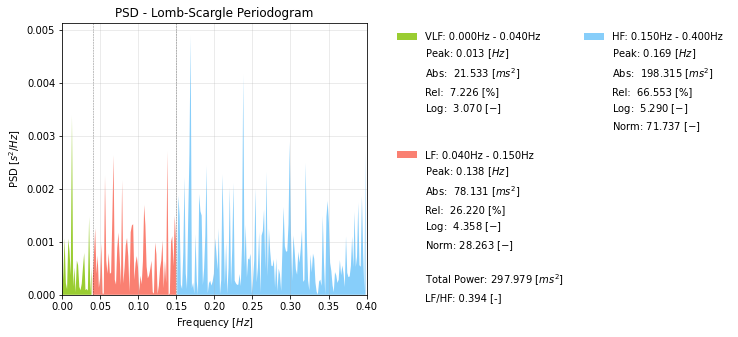

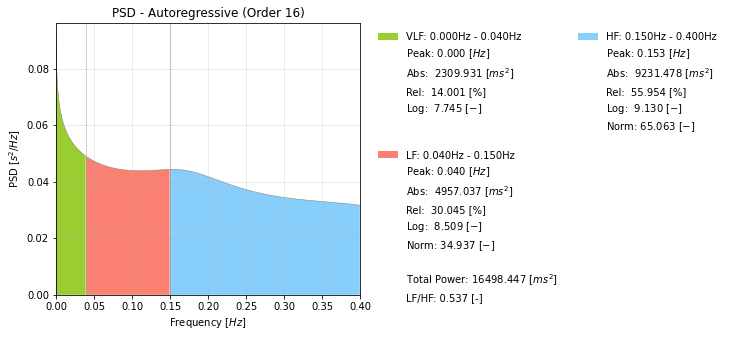

In [ ]:
frequency_results = pyhrv.frequency_domain.frequency_domain(nni=rr, sampling_rate=100.0)

# Referencias
[1] T. Nguyen, X. Qin, A. Dinh, and F. Bui, “Low resource complexity R-peak detection based on triangle template matching and moving average filter,” Sensors (Switzerland), vol. 19, no. 18, 2019.